# Kaiser Window State for Quantum Phase Estimation

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `KaiserWindowState`
Bloq to prepare a Kaiser window state for high confidence Quantum Phase Estimation.

Kaiser window states are optimal to minimize the probability of error outside a given
confidence interval.
Given the bitsize $m$ and parameter $\alpha$, the bloq prepares an $m$-bit state with
coefficients

$$
    \sum\limits_{x=-M}^{M}\frac{1}{2M} \frac{I_0\left(\pi\alpha\sqrt{1-(x/M)^2}\right)}{I_0\left(\pi\alpha\right)}\ket{x}
$$

where $M = 2^{m-1}$. See Ref[1] for more details.


#### Parameters
 - `bitsize`: Number of bits in the control register of QPE.
 - `alpha`: Shape parameter, determines trade-off between main-lobe width and side lobe level. 

#### References
 - [Analyzing Prospects for Quantum Advantage in Topological Data Analysis](https://arxiv.org/abs/2209.13581). Berry et al. (2022). Appendix D


In [2]:
from qualtran.bloqs.phase_estimation.kaiser_window_state import KaiserWindowState

### Example Instances

In [3]:
kaiser_window_state_small = KaiserWindowState(5, 2)

In [4]:
import sympy

kaiser_window_state_symbolic = KaiserWindowState(*sympy.symbols('n, alpha'))

#### Graphical Signature

In [5]:
from qualtran.drawing import show_bloqs
show_bloqs([kaiser_window_state_small, kaiser_window_state_symbolic],
           ['`kaiser_window_state_small`', '`kaiser_window_state_symbolic`'])

### Call Graph

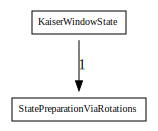

#### Counts totals:
 - `StatePreparationViaRotations`: 1

In [6]:
from qualtran.resource_counting.generalizers import ignore_split_join
kaiser_window_state_small_g, kaiser_window_state_small_sigma = kaiser_window_state_small.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(kaiser_window_state_small_g)
show_counts_sigma(kaiser_window_state_small_sigma)

## Example of QPE comparing different window functions

In [7]:
import cirq
import numpy as np
from qualtran import BloqBuilder, CompositeBloq
from qualtran.bloqs.basic_gates import ZPowGate, OneState, OneEffect
from qualtran.bloqs.phase_estimation import TextbookQPE, RectangularWindowState, LPResourceState, KaiserWindowState

In [8]:
def construct_composite_boq(bloq: TextbookQPE) -> CompositeBloq:
    bb = BloqBuilder()
    q = bb.add(OneState())
    phase_reg, q = bb.add(bloq, q=q)
    bb.add(OneEffect(), q=q)
    return bb.finalize(phase_reg=phase_reg)

def simulate_theta_estimate(bloq: TextbookQPE, n_samples: int) -> float:
    cbloq = construct_composite_boq(bloq)
    final_state = cbloq.tensor_contract()
    samples = cirq.sample_state_vector(final_state, indices=[*range(bloq.m_bits)], repetitions=n_samples)
    thetas = samples.dot(1 << np.arange(samples.shape[-1] - 1, -1, -1))
    return thetas

def holevo_variance(thetas):
    mu = np.mean(np.cos(thetas - theta))
    return 1 / mu**2 - 1

In [9]:
theta = 0.51234
unitary = ZPowGate(2 * theta)
n_samples = 100_000
m = 6
x_vals = [x / 2**m for x in range(2**m)]
# Textbook QPE
qpe_textbook = TextbookQPE(unitary, RectangularWindowState(m))
thetas_textbook = simulate_theta_estimate(qpe_textbook, n_samples)
# SinState QPE
qpe_sinstate = TextbookQPE(unitary, LPResourceState(m))
thetas_sinstate = simulate_theta_estimate(qpe_sinstate, n_samples)
# Kaiser QPE
kaiser_window_state = KaiserWindowState.from_precision_and_delta(3, 1e-2)
alpha = kaiser_window_state.alpha
assert kaiser_window_state.bitsize == m, f'{kaiser_window_state.bitsize}'
qpe_kaiser_state = TextbookQPE(unitary, kaiser_window_state)
thetas_kaiser_state = simulate_theta_estimate(qpe_kaiser_state, n_samples)

/usr/local/google/home/mpharrigan/qualtran/conda-311/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:57: UserWarning: Couldn't find `optuna`, `cmaes`, `baytune (btb)`, `chocolate`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/usr/local/google/home/mpharrigan/qualtran/conda-311/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:76: UserWarning: Couldn't find `optuna`, `cmaes`, `baytune (btb)`, `chocolate`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


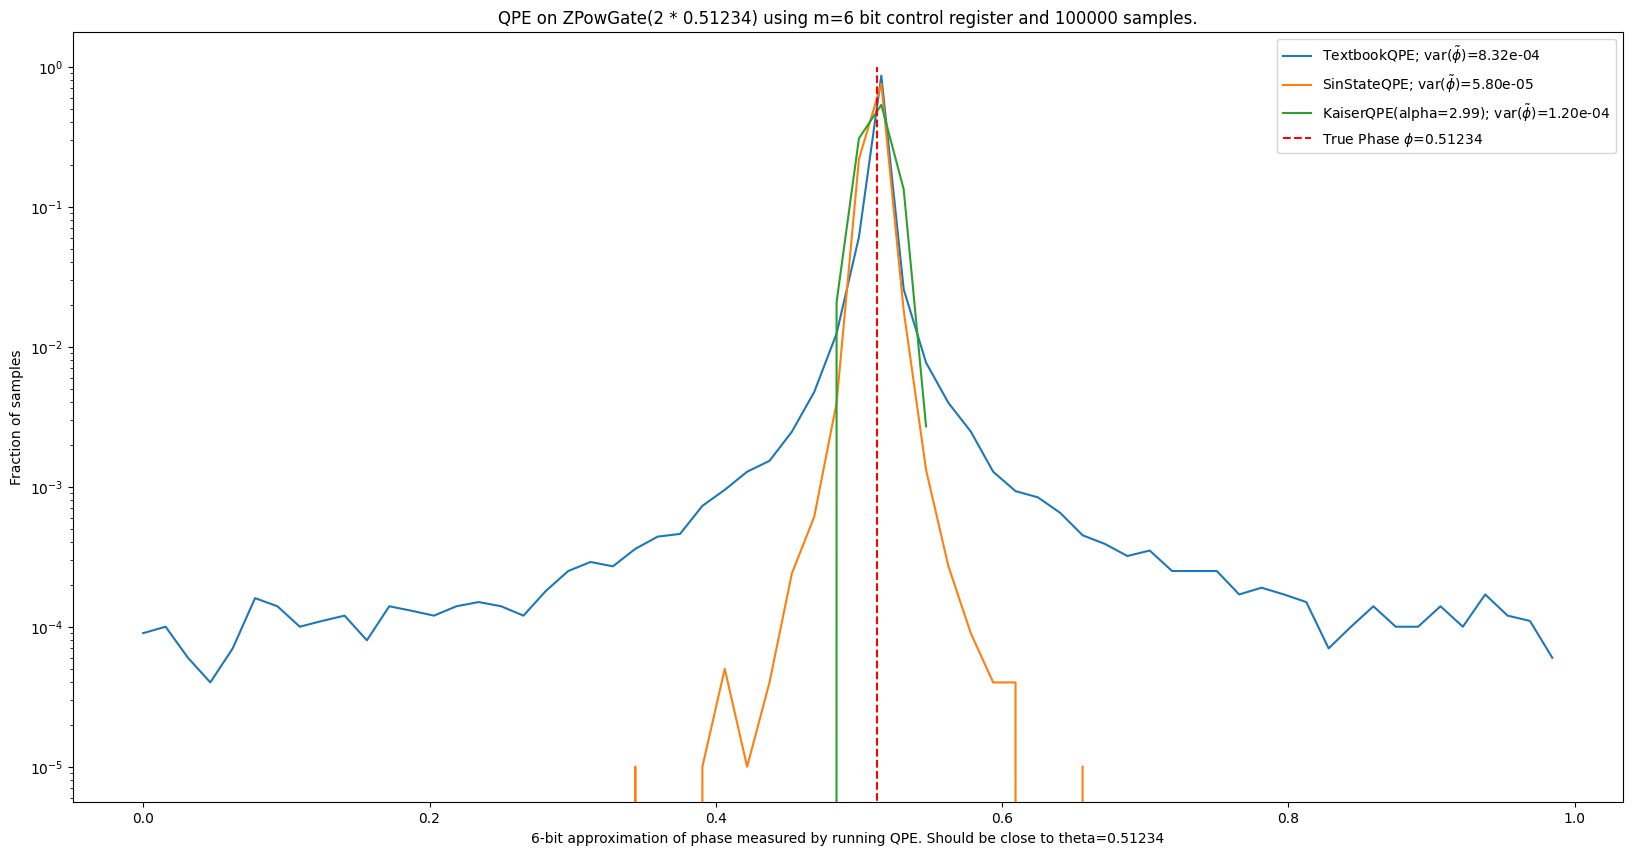

In [10]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 10)

theta_counts_textbok = np.bincount(thetas_textbook) / n_samples
theta_counts_sinstate = np.bincount(thetas_sinstate) / n_samples
theta_counts_kaiser = np.bincount(thetas_kaiser_state) / n_samples
var_textbook = holevo_variance(thetas_textbook / 2**m)
var_sinstate = holevo_variance(thetas_sinstate / 2**m)
var_kaiser = holevo_variance(thetas_kaiser_state / 2**m)

plt.plot(np.array(x_vals[:len(theta_counts_textbok)]), theta_counts_textbok, label=r"TextbookQPE; var($\tilde{\phi}$)="f"{var_textbook:.2e}")
plt.plot(np.array(x_vals[:len(theta_counts_sinstate)]), theta_counts_sinstate, label=r"SinStateQPE; var($\tilde{\phi}$)="f"{var_sinstate:.2e}")
plt.plot(np.array(x_vals[:len(theta_counts_kaiser)]), theta_counts_kaiser, label=f"KaiserQPE({alpha=:0.3}); "r"var($\tilde{\phi}$)="f"{var_kaiser:.2e}")
plt.vlines(theta, 0, 1, linestyles='--', label=f'True Phase $\phi$={theta}', colors='red')
plt.yscale('log', base=10)
plt.ylabel(f'Fraction of samples')
plt.xlabel(f'{m}-bit approximation of phase measured by running QPE. Should be close to {theta=}')
plt.title(f'QPE on ZPowGate(2 * {theta}) using {m=} bit control register and {n_samples} samples.')
plt.legend()
plt.show()